This notebook calculates and plots a time series of the amplitude dispersion over a time window (~10 dates?) and plots it. Can work with any pixel.

<br><br>
Written 1-30-24. 
***
***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.dates as mdates
%matplotlib  widget

Extract dates.

In [2]:
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates)
# convert them to datetime objects for plotting the time series 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))

Load amp disp map for all pixels for all times. Compare to individual pixels' results for double checking.

Amplitude dispersion for each pixel loaded.


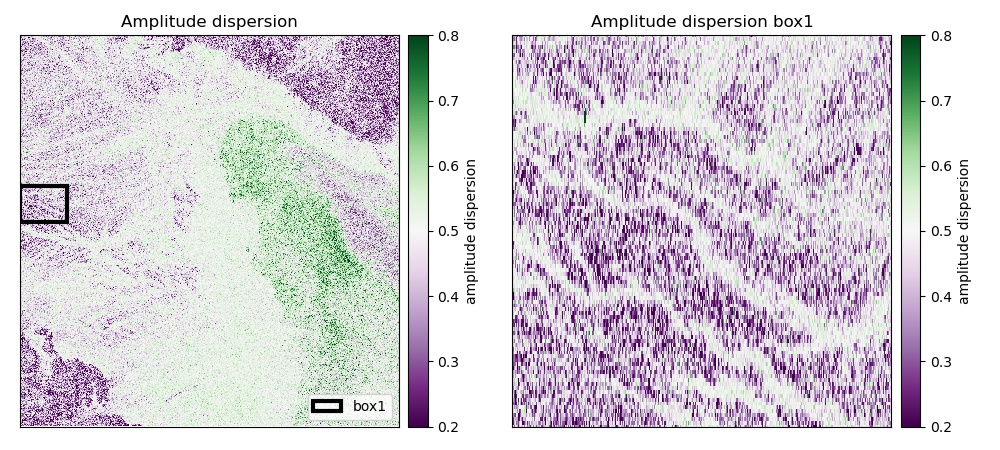

In [3]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# want to plot the boxes?
plotBoxes = True
box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]
plt.figure(figsize=(10,4.5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(amp_dispersion,aspect='auto',cmap='PRGn',interpolation='nearest',vmin=0.2,vmax=0.8)
plt.colorbar(orientation='vertical',pad=0.02,label='amplitude dispersion')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
if plotBoxes==True:
    plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
    plt.legend(loc='lower right')
plt.title('Amplitude dispersion')
plt.subplot(1,2,2)
plt.imshow(amp_dispersion,aspect='auto',cmap='PRGn',interpolation='nearest',vmin=0.2,vmax=0.8)
plt.colorbar(orientation='vertical',pad=0.02,label='amplitude dispersion')
plt.xlim([box1x[1],box1x[0]]); plt.ylim([box1y[1],box1y[0]]); plt.xticks([]); plt.yticks([])
plt.title('Amplitude dispersion box1')
plt.show()

These are the borders to the crop window. The pixel I define later will be within these points and x2,y2 will need to be added to extract amplitude info at the right pixel.

In [4]:
# shape of my cropped area
# larger box with western mtns
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

What point do we want to extract the amp time series at? 

In [5]:
# Choose a point to extract the amp disp time series at 
y = 472
x = 3836

Read in the amplitude at that pixel for all dates. 

In [6]:
amps = np.ndarray((nd,),dtype='float')
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# load in amp at the chosen pixel for all SLCs 
for i in range(nd): #nd
    # Read in the section of the SLC  
    ds = gdal.Open(datesDir+'SLC_vv/'+dates[i]+'/'+dates[i]+'.slc.full', gdal.GA_ReadOnly)
    pixel_val = ds.GetRasterBand(1).ReadAsArray(x2+x,y2+y,1,1)[0,0]
    amps[i] = np.abs(pixel_val)
print('Amps loaded for chosen pixel.')

Amps loaded for chosen pixel.


Plot the amplitude over time. 

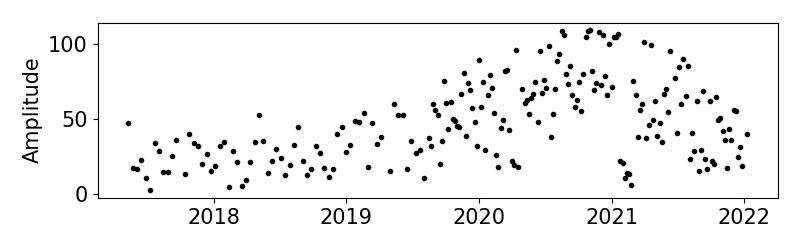

In [7]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8,2.5),tight_layout=True)
plt.plot(slc_dates,amps,'k.')
plt.ylabel('Amplitude')
plt.show()

Now run an 11-date moving window and pull out std and mean for each time window. Pull out midpoint dates also. 

In [8]:
tWindow = 21
amp_disp_dates = slc_dates[int((tWindow-1)/2):-int((tWindow-1)/2)]
amp_disps = np.ndarray((nd-(tWindow-1),))
j=0
for i in np.arange(int((tWindow-1)/2),nd-int((tWindow-1)/2),1):
    #print(i-int((tWindow-1)/2),i+int((tWindow-1)/2)+1)
    window_amps = amps[i-int((tWindow-1)/2):i+int((tWindow-1)/2)+1]
    #print(np.shape(window_amps))
    temp_amp_disp = np.std(window_amps)/np.mean(window_amps)
    amp_disps[j] = temp_amp_disp
    j = j+1

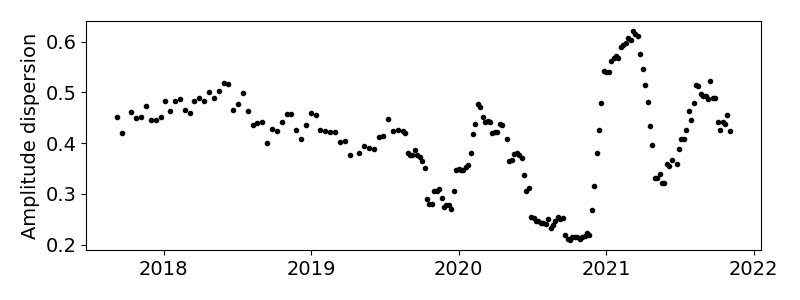

In [9]:
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,3),tight_layout=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
plt.plot(amp_disp_dates,amp_disps,'k.')
plt.ylabel('Amplitude dispersion')
plt.show()

Make a function for adding vertical precip lines colored by magnitude to any time series plot. <br>

In [10]:
# Read in raw precipitation data and plot it 
file = '/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip.txt'
precip_all = np.loadtxt(file, delimiter=',', skiprows=3, dtype=str)
precipDates = precip_all[:,0]
precip_all = precip_all[:,1]
precip_all = precip_all.astype(float)
# convert to cm from inches 
precip_all = precip_all*2.54
# make the dates from precip.txt into datetime objects
my_dates=[]
for i in range(0,len(precipDates)):
    my_dates.append(datetime.strptime(str(precipDates[i]).replace('\n',''), '%Y-%m-%d'))
rainy_dates = []
rainy_amts = []
for i in np.arange(len(precip_all)): 
    if precip_all[i] > 0.3:
        print(str(i)+'\t'+str(my_dates[i])+'    '+str(precip_all[i])+' cm')
        rainy_dates.append(my_dates[i])
        rainy_amts.append(precip_all[i])
rainy_amts2 = np.ndarray((np.shape(rainy_amts)),dtype='float')
for i in range(len(rainy_amts)):
    rainy_amts2[i] = float(rainy_amts[i])
# normalize to the largest rain event so all values are btw 0-1
rainy_amts2 = rainy_amts2/np.max(rainy_amts)
rainy_amts2 = 0.8*rainy_amts2+0.2

def plot_precip(fig): 
    # ALL rainy days (not just day of/prior to an SLC date)
    Ymin,Ymax = plt.gca().get_ylim()
    plt.vlines(rainy_dates,Ymin,Ymax,'k',zorder=1,alpha=rainy_amts2)
    plt.ylim([Ymin,Ymax])

584	2018-12-06 00:00:00    0.48260000000000003 cm
585	2018-12-07 00:00:00    4.572 cm
615	2019-01-06 00:00:00    0.5334 cm
641	2019-02-01 00:00:00    0.381 cm
878	2019-09-26 00:00:00    1.4478 cm
933	2019-11-20 00:00:00    2.286 cm
934	2019-11-21 00:00:00    1.016 cm
942	2019-11-29 00:00:00    1.016 cm
970	2019-12-27 00:00:00    0.9398 cm
1016	2020-02-11 00:00:00    1.1684 cm
1044	2020-03-10 00:00:00    0.7365999999999999 cm
1045	2020-03-11 00:00:00    2.4892 cm
1047	2020-03-13 00:00:00    0.3556 cm
1073	2020-04-08 00:00:00    0.6096 cm
1076	2020-04-11 00:00:00    0.9906 cm
1360	2021-01-20 00:00:00    0.3556 cm
1361	2021-01-21 00:00:00    1.7779999999999998 cm
1563	2021-08-11 00:00:00    0.381 cm
1584	2021-09-01 00:00:00    0.7112 cm
1698	2021-12-24 00:00:00    0.7112 cm


In [11]:
# make the extracting the time series into a function
# nd, x2, y2 need to be hard-coded already
def extract_amp_disp_TS(x,y,tWindow):
    amps = np.ndarray((nd,),dtype='float')
    # set the driver first, only do once.
    driver=gdal.GetDriverByName('ISCE')
    # load in amp at the chosen pixel for all SLCs 
    for i in range(nd): #nd
        # Read in the section of the SLC  
        ds = gdal.Open(datesDir+'SLC_vv/'+dates[i]+'/'+dates[i]+'.slc.full', gdal.GA_ReadOnly)
        pixel_val = ds.GetRasterBand(1).ReadAsArray(x2+x,y2+y,1,1)[0,0]
        amps[i] = np.abs(pixel_val)
    #print('Amps loaded for chosen pixel.')
    amp_disp_dates = slc_dates[int((tWindow-1)/2):-int((tWindow-1)/2)]
    amp_disps = np.ndarray((nd-(tWindow-1),))
    j=0
    for i in np.arange(int((tWindow-1)/2),nd-int((tWindow-1)/2),1):
        #print(i-int((tWindow-1)/2),i+int((tWindow-1)/2)+1)
        window_amps = amps[i-int((tWindow-1)/2):i+int((tWindow-1)/2)+1]
        #print(np.shape(window_amps))
        temp_amp_disp = np.std(window_amps)/np.mean(window_amps)
        amp_disps[j] = temp_amp_disp
        j = j+1
    return amp_disp_dates, amp_disps

def extract_amp_TS(x,y,tWindow):
    amps = np.ndarray((nd,),dtype='float')
    # set the driver first, only do once.
    driver=gdal.GetDriverByName('ISCE')
    # load in amp at the chosen pixel for all SLCs 
    for i in range(nd): #nd
        # Read in the section of the SLC  
        ds = gdal.Open(datesDir+'SLC_vv/'+dates[i]+'/'+dates[i]+'.slc.full', gdal.GA_ReadOnly)
        pixel_val = ds.GetRasterBand(1).ReadAsArray(x2+x,y2+y,1,1)[0,0]
        amps[i] = np.abs(pixel_val)
    return amps

# make a function for plotting it 
def plot_amp_disp_TS(x1,y1,x2,y2,tWindow):
    dates, ad1 = extract_amp_disp_TS(x1,y1,tWindow)
    dates, ad2 = extract_amp_disp_TS(x2,y2,tWindow)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(8,4),tight_layout=True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.plot(dates,ad1,'k.',markersize=10,label='Pixel 1')
    plt.plot(dates,ad2,'m.',markersize=10,label='Pixel 2')
    plot_precip(fig)
    plt.legend()
    plt.ylabel('Amplitude dispersion')
    plt.title('Pixel 1 ('+str(y1)+', '+str(x1)+')'+'   Pixel 2 ('+str(y2)+', '+str(x2)+')')
    plt.show()

# make a function for plotting it 
def plot_amp_TS(x1,y1,x2,y2,tWindow):
    amp1 = extract_amp_TS(x1,y1,tWindow)
    amp2 = extract_amp_TS(x2,y2,tWindow)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(8,4),tight_layout=True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.plot(slc_dates,amp1,'k.',markersize=10,label='Pixel 1')
    plt.plot(slc_dates,amp2,'m.',markersize=10,label='Pixel 2')
    plot_precip(fig)
    plt.legend()
    plt.ylabel('Amplitude')
    plt.title('Pixel 1 ('+str(y1)+', '+str(x1)+')'+'   Pixel 2 ('+str(y2)+', '+str(x2)+')')
    plt.show()

def plot_both_TS(x1,y1,x2,y2,tWindow):
    dates, ad1 = extract_amp_disp_TS(x1,y1,tWindow)
    dates, ad2 = extract_amp_disp_TS(x2,y2,tWindow)
    amp1 = extract_amp_TS(x1,y1,tWindow)
    amp2 = extract_amp_TS(x2,y2,tWindow)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(14,4),tight_layout=True)
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.plot(dates,ad1,'k.',markersize=10,label='Pixel 1')
    plt.plot(dates,ad2,'m.',markersize=10,label='Pixel 2')
    plot_precip(fig)
    plt.legend()
    plt.ylabel('Amplitude dispersion')
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.plot(slc_dates,amp1,'k.',markersize=10,label='Pixel 1')
    plt.plot(slc_dates,amp2,'m.',markersize=10,label='Pixel 2')
    plot_precip(fig)
    plt.legend()
    plt.ylabel('Amplitude')
    plt.suptitle('Pixel 1 ('+str(y1)+', '+str(x1)+')'+'   Pixel 2 ('+str(y2)+', '+str(x2)+')')
    plt.show()

Load in the SLCs, igrams, and filt igrams (filter the raw ones), so I can calculate the hp phase stability at any point over a moving time window. This way, it can load them all in once and the function pulls out the HP phase stability time series at any one point, can do this for multiple points without repeating the loading and filtering steps.

In [12]:
# THIS ISN'T THE MOST EFFICIENT 
# Loads in entire SLCs, makes raw igram, filters it, then extracts a single value from each. This was the easiest for now. 
driver=gdal.GetDriverByName('ISCE')
dir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'  
# filter size
alooks=4
rlooks=20
# initialize array for the hp phase for each date. 
# Later, will accumulate this over moving window at a point to calculate hp phase stability.
hp = np.ndarray((nd-1,dy,dx),dtype='complex')
# loop through SLCs, load two in at a time, make the igram, filter it, save them to two diff arrays 
for i in range(nd-1): # 211 SLCs, 210 igrams, 209 triplets 
    dateA=dates[i]; dateB=dates[i+1]
    # load SLC A (complex)
    ds = gdal.Open(dir+"/SLC_vv/"+dateA+"/"+dateA+".slc.full", gdal.GA_ReadOnly)
    slcA = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
    # load SLC B (complex)
    ds = gdal.Open(dir+"/SLC_vv/"+dateB+"/"+dateB+".slc.full", gdal.GA_ReadOnly)
    slcB = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
    # calculate the interferogram
    intAB = slcA * np.conj(slcB)
    #filter the igram: real part, then imaginary part 
    filtintr = gaussian_filter(np.real(intAB),sigma=[alooks/4,rlooks/4])
    filtinti = gaussian_filter(np.imag(intAB),sigma=[alooks/4,rlooks/4])
    filtAB = filtintr+1j*filtinti
    # take phase of full res igram minus filtered version
    phs_diff = np.angle(intAB) - np.angle(filtAB)
    hp[i] = np.exp(1j*phs_diff)
    if i%10 == 0:
        print('igram '+str(i)+' done.')
    print('all done.')

igram 0 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 10 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 20 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 30 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 40 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 50 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 60 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 70 done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
all done.
igram 80 done.
all done.
all done.
all done.
all done.
all done.
all done.
all do

In [13]:
def extract_hp_phs_TS(x,y,tWindow):
    hp_phs_dates = slc_dates[int((tWindow-1)/2):-int((tWindow-1)/2)]
    hp_phs = np.ndarray((nd-(tWindow-1),))
    hp_at_pixel = hp[:,y,x]
    # print(np.shape(hp_at_pixel))
    # moving window over the hp array at a point
    j=0
    for i in np.arange(int((tWindow-1)/2),nd-int((tWindow-1)/2),1):
        window_hp = hp_at_pixel[i-int((tWindow-1)/2):i+int((tWindow-1)/2)+1]
        hp_phs[j] = np.abs(np.sum(window_hp))/(tWindow)
        j = j+1
    return hp_phs_dates, hp_phs

def plot_hp_phs_TS(x1,y1,x2,y2,tWindow):
    hp_dates, hp1 = extract_hp_phs_TS(x1,y1,tWindow)
    hp_dates, hp2 = extract_hp_phs_TS(x2,y2,tWindow)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(8,4),tight_layout=True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.plot(hp_dates,hp1,'k.',markersize=10,label='Pixel 1')
    plt.plot(hp_dates,hp2,'m.',markersize=10,label='Pixel 2')
    plot_precip(fig)
    plt.legend()
    plt.ylabel('HP Phase stability')
    plt.title('Pixel 1 ('+str(y1)+', '+str(x1)+')'+'   Pixel 2 ('+str(y2)+', '+str(x2)+')')
    plt.show()

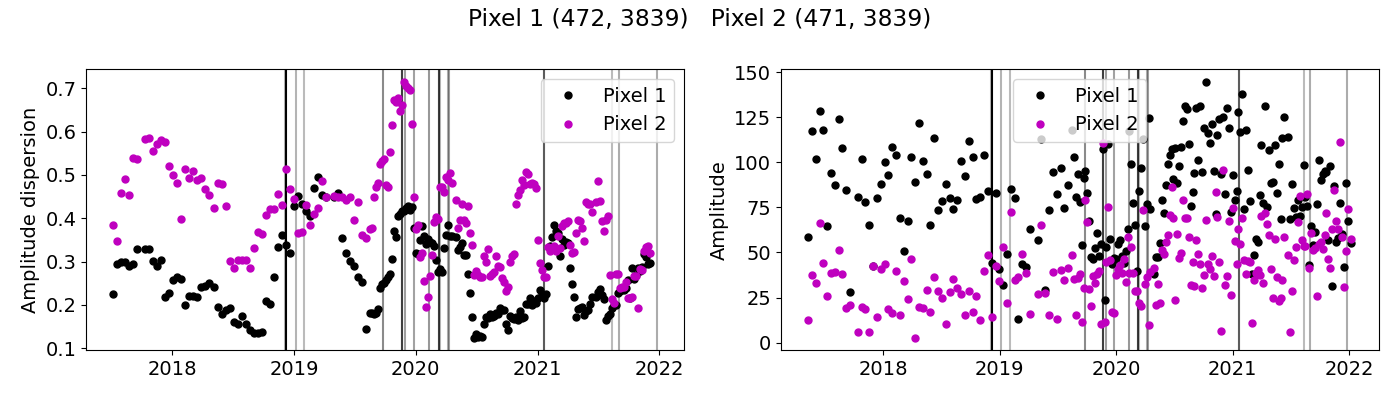

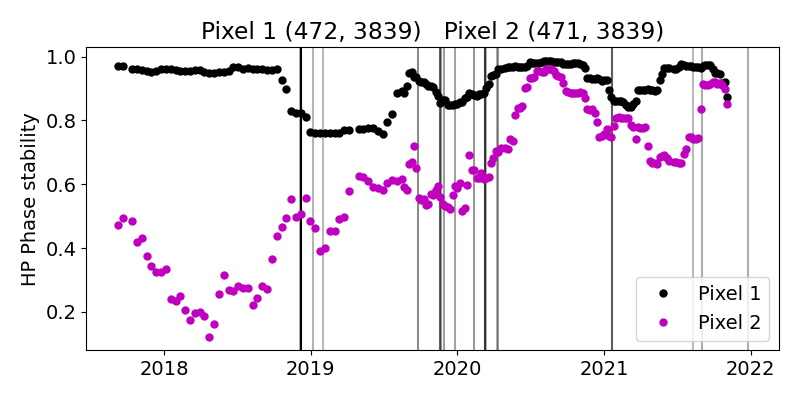

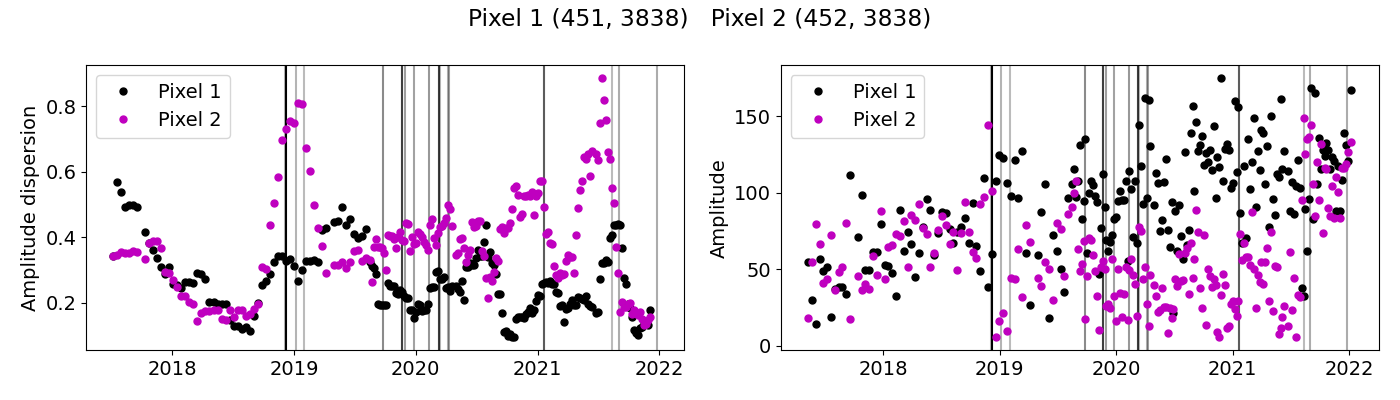

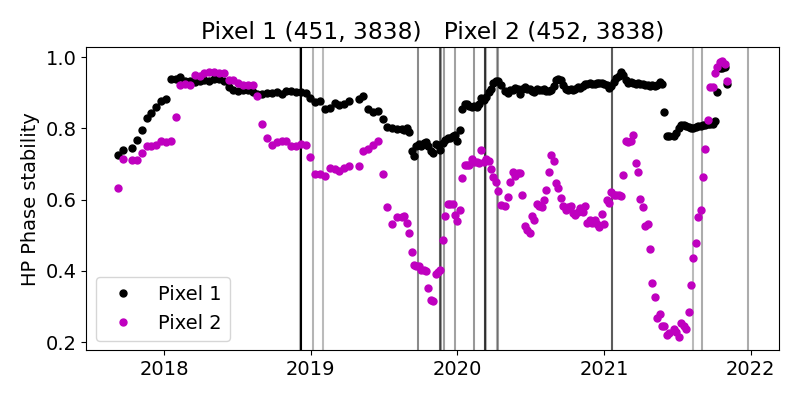

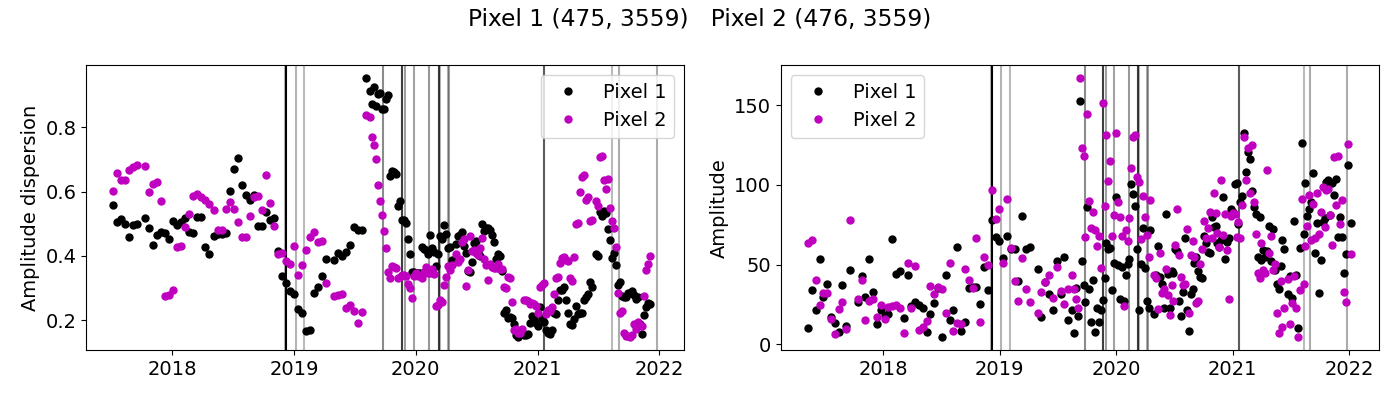

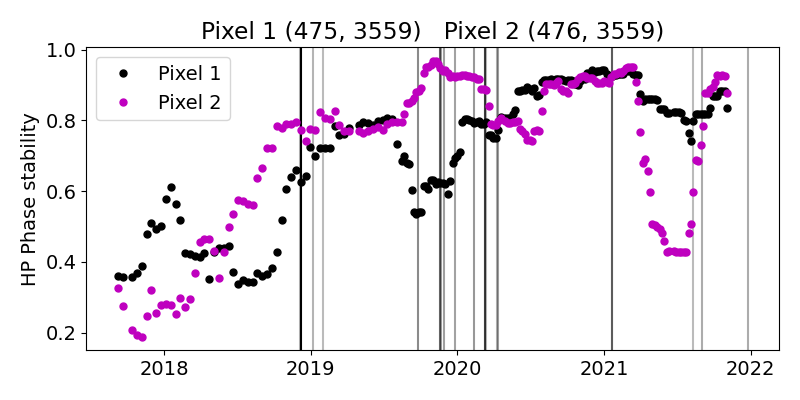

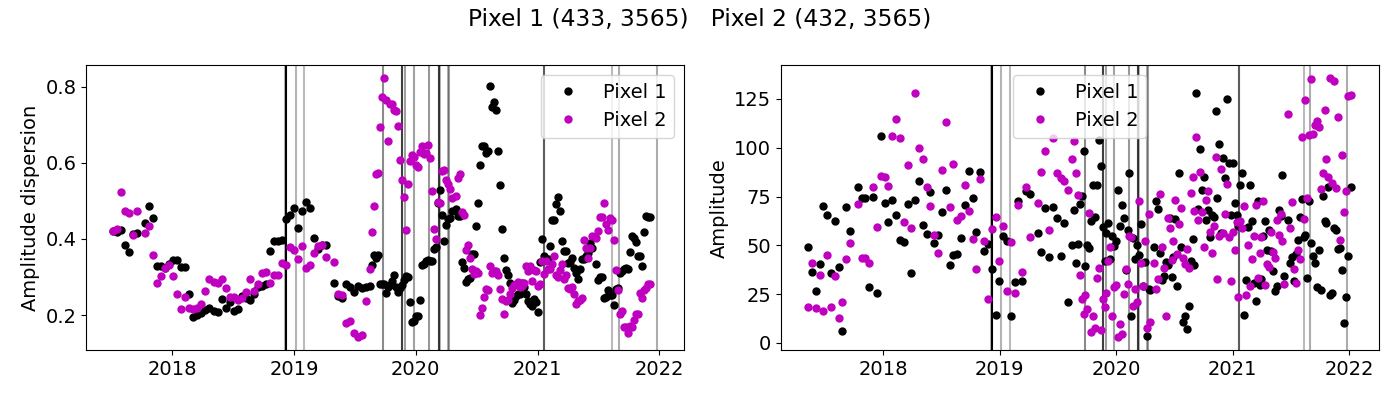

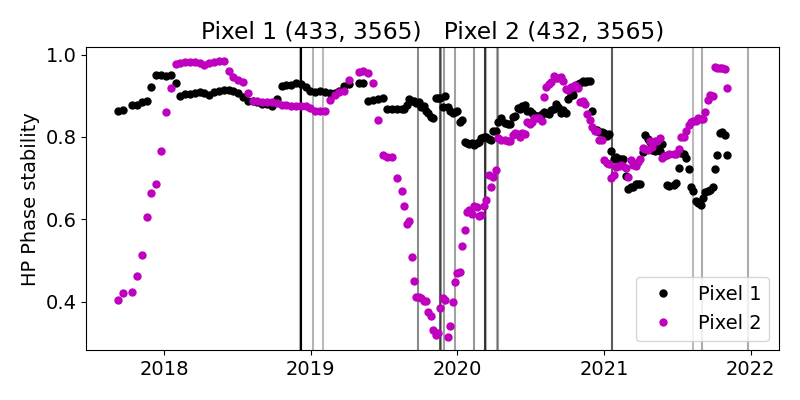

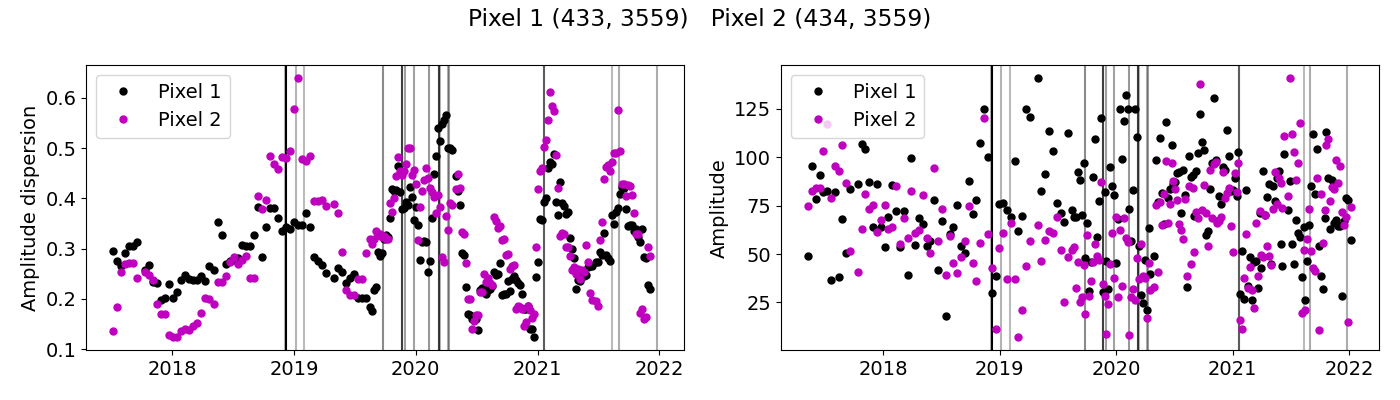

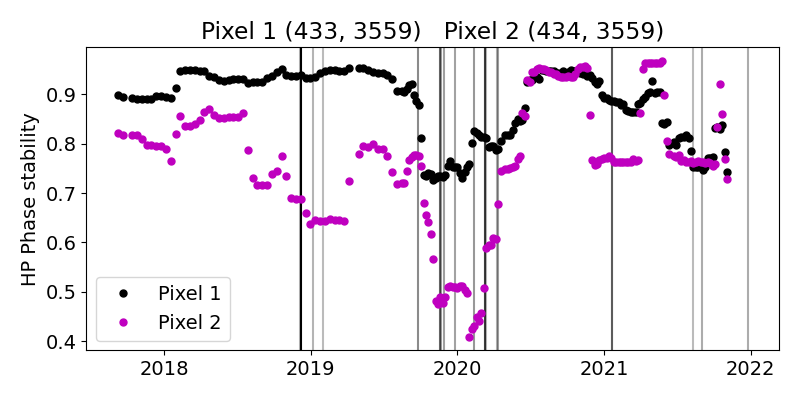

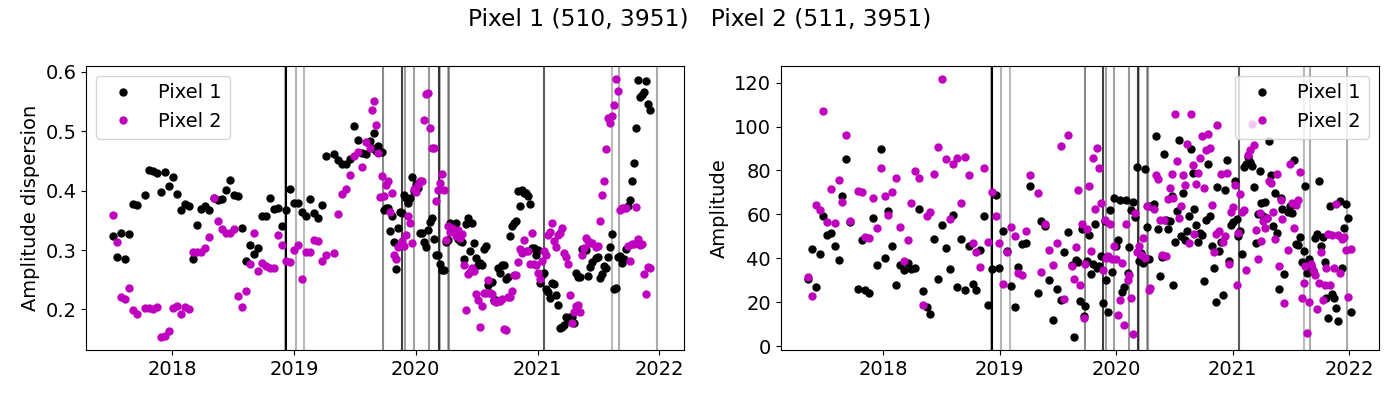

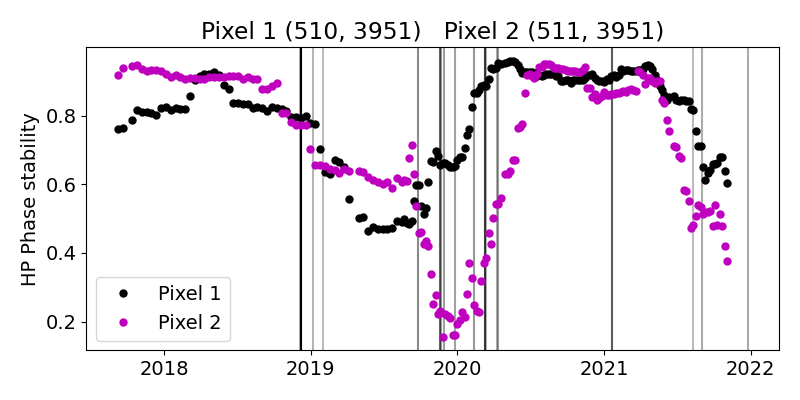

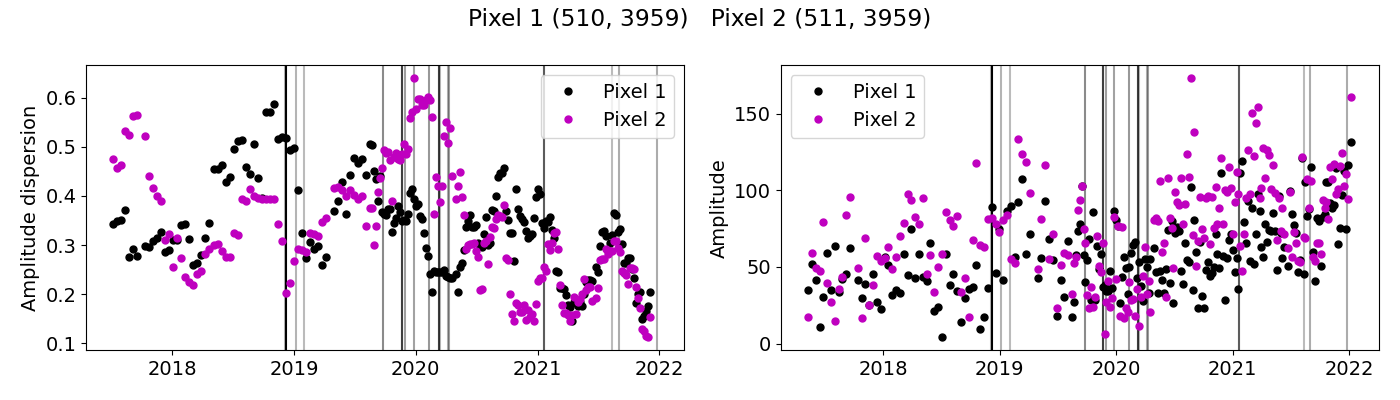

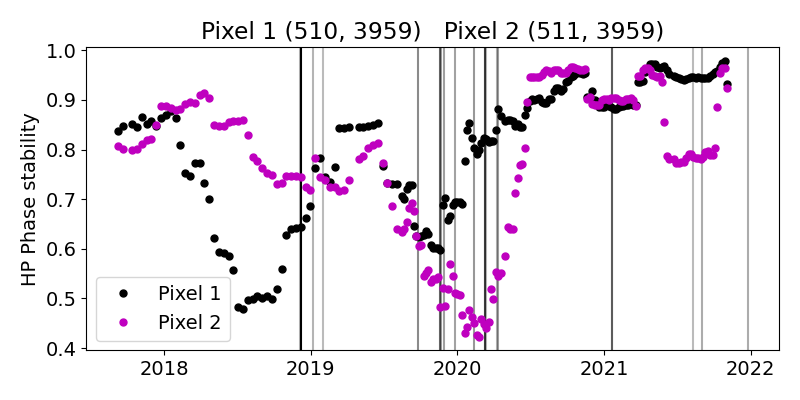

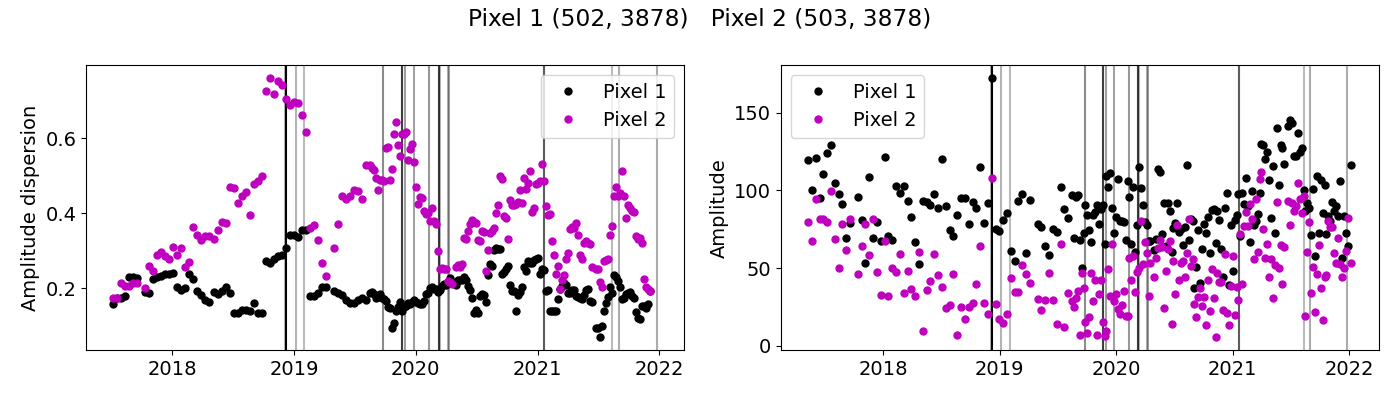

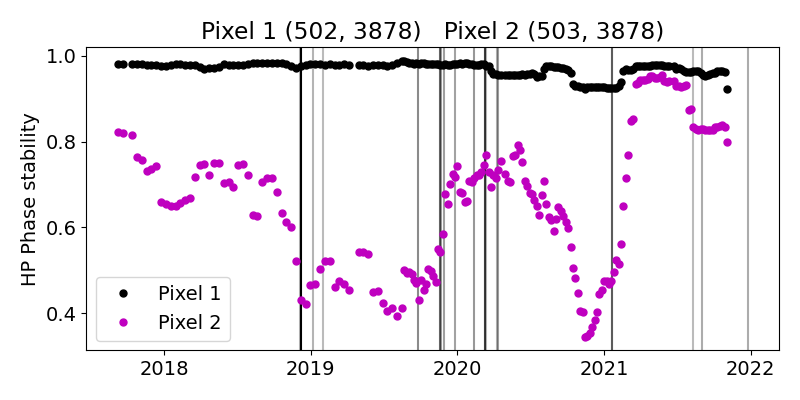

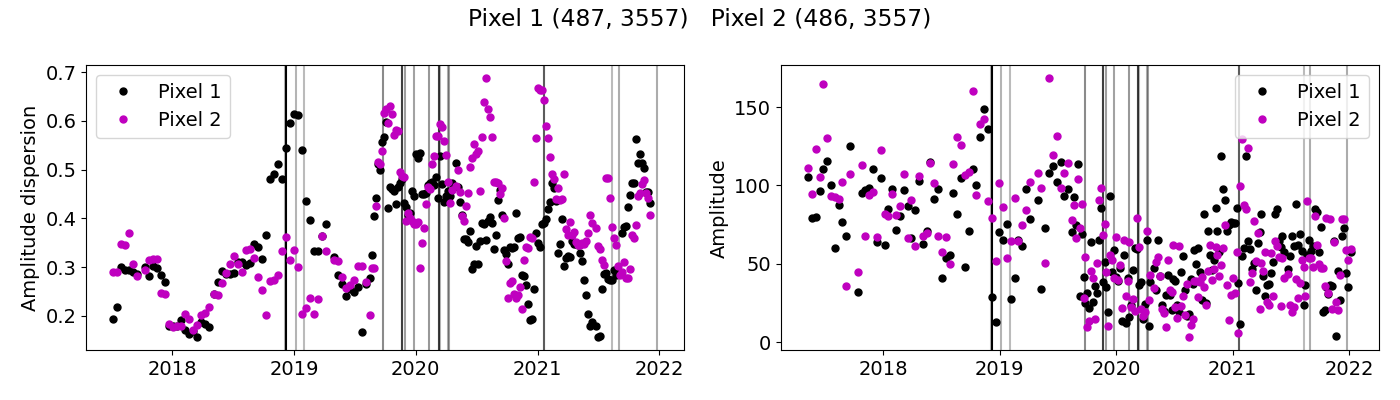

/tmp/ipykernel_2198609/4280798544.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,4),tight_layout=True)


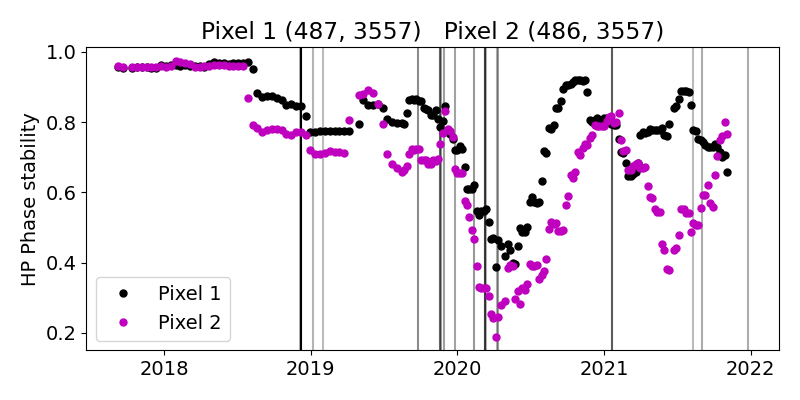

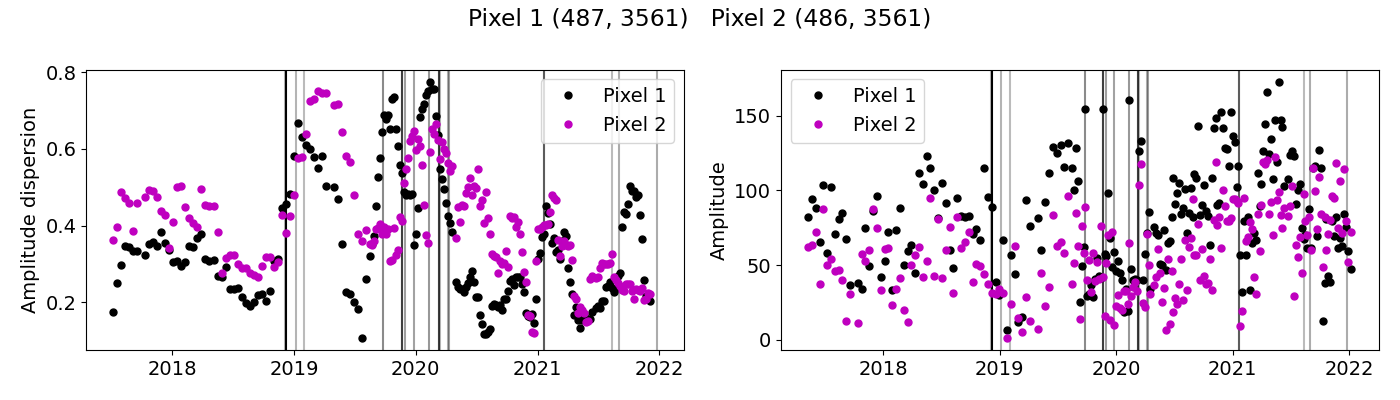

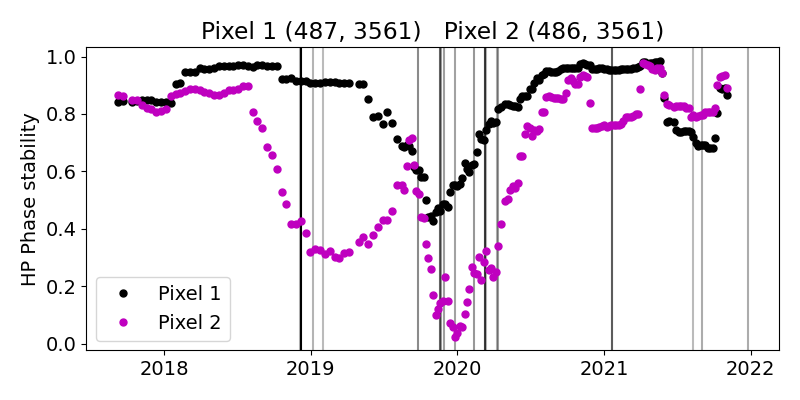

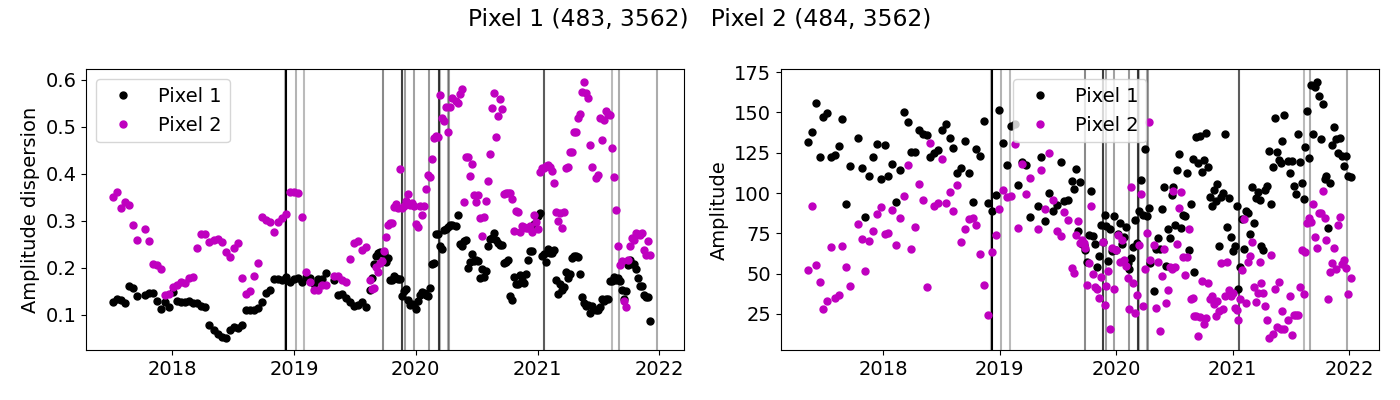

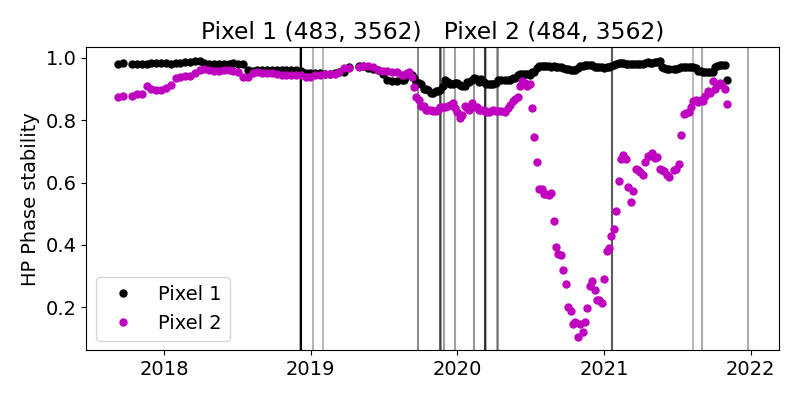

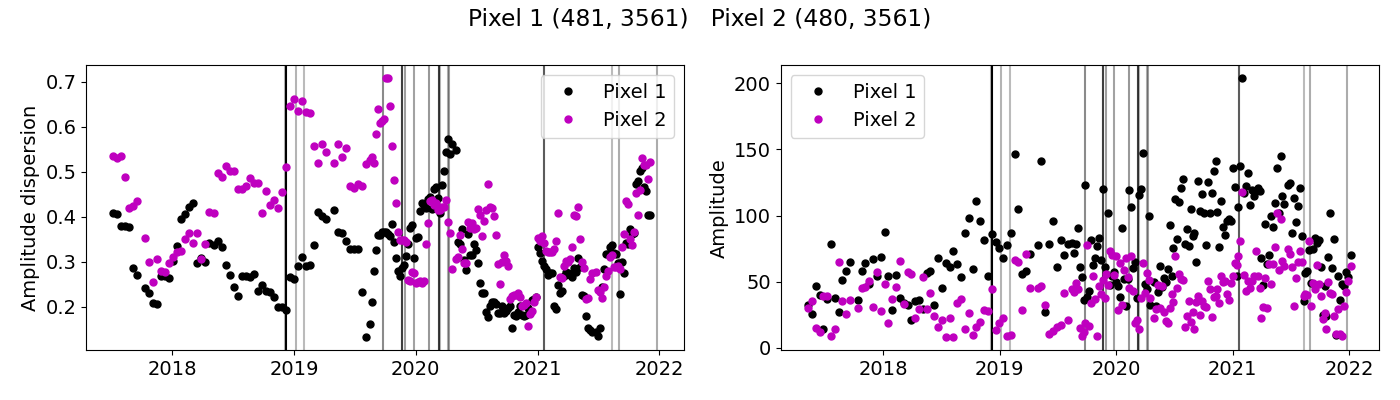

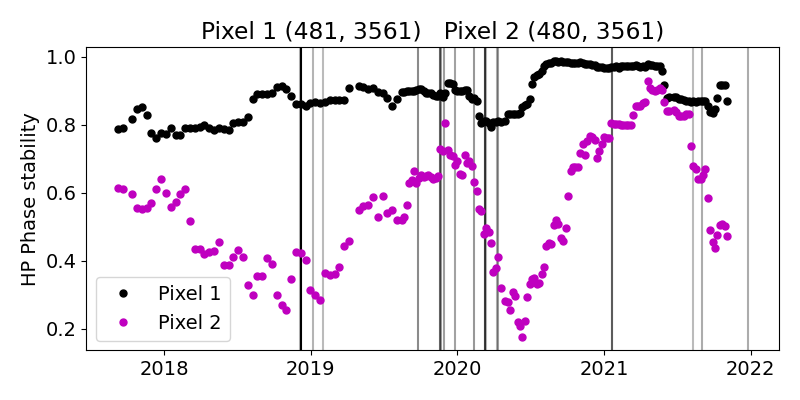

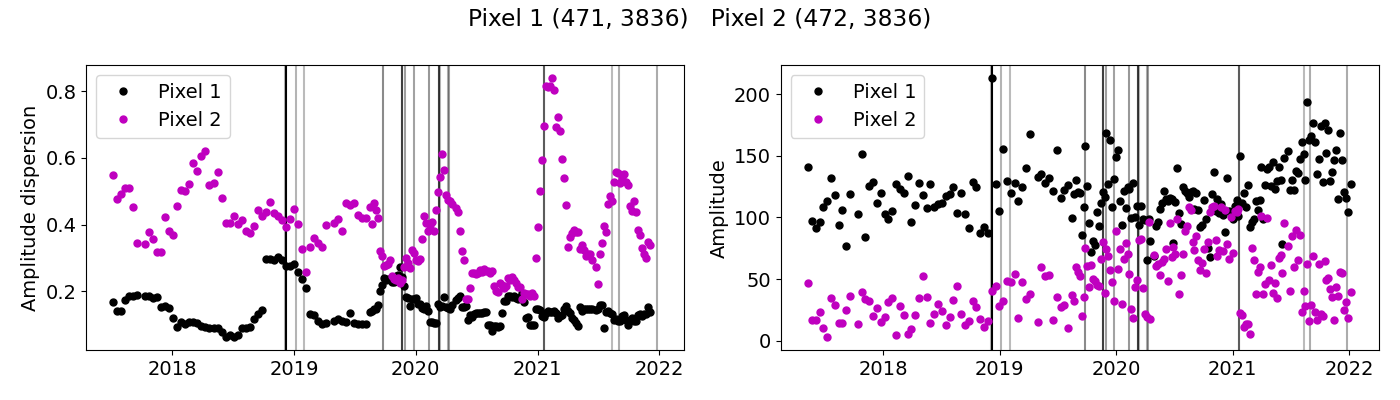

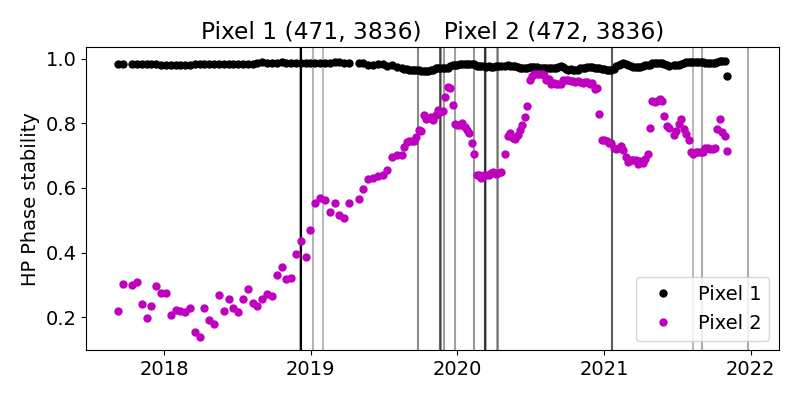

In [14]:
tWindow = 21

# current
plot_both_TS(3839,472,3839,471,11); plot_hp_phs_TS(3839,472,3839,471,tWindow)
plot_both_TS(3838,451,3838,452,11); plot_hp_phs_TS(3838,451,3838,452,tWindow)
# candidates
plot_both_TS(3559,475,3559,476,11); plot_hp_phs_TS(3559,475,3559,476,tWindow)
plot_both_TS(3565,433,3565,432,11); plot_hp_phs_TS(3565,433,3565,432,tWindow)
plot_both_TS(3559,433,3559,434,11); plot_hp_phs_TS(3559,433,3559,434,tWindow)
plot_both_TS(3951,510,3951,511,11); plot_hp_phs_TS(3951,510,3951,511,tWindow)
plot_both_TS(3959,510,3959,511,11); plot_hp_phs_TS(3959,510,3959,511,tWindow)
plot_both_TS(3878,502,3878,503,11); plot_hp_phs_TS(3878,502,3878,503,tWindow)
plot_both_TS(3557,487,3557,486,11); plot_hp_phs_TS(3557,487,3557,486,tWindow)
plot_both_TS(3561,487,3561,486,11); plot_hp_phs_TS(3561,487,3561,486,tWindow)
plot_both_TS(3562,483,3562,484,11); plot_hp_phs_TS(3562,483,3562,484,tWindow)
plot_both_TS(3561,481,3561,480,11); plot_hp_phs_TS(3561,481,3561,480,tWindow)
plot_both_TS(3836,471,3836,472,11); plot_hp_phs_TS(3836,471,3836,472,tWindow)